In [2]:
import numpy as np
from sklearn.cluster import KMeans
#from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from wordcloud import WordCloud
from unidecode import unidecode
import scipy
#import torch
from sentence_transformers import SentenceTransformer
import umap

/Users/leonardosales/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Importando modelo pré-treinado Bert sentence-embedding
model_path="paraphrase-distilroberta-base-v1"
model = SentenceTransformer(model_path)

### Dados

In [5]:
# Carregando base de leis 2023
leis = pd.read_excel('planilha_leis.xlsx')
leis['assunto_limpo'] = leis['assunto'].apply(lambda x: unidecode(x).lower())
leis['assunto_lista_termos'] = leis['assunto_limpo'].apply(lambda x: x.replace(',', '').replace(';', '').replace(':', '').replace('.', '').replace('"', '').replace('-', '').replace('(', '').replace(')', '').split(' '))

leis.head()

,lei,assunto,assunto_limpo,assunto_lista_termos
0,"Lei nº 14.791, de 29.12.2023Publicada no DOU d...",Dispõe sobre as diretrizes para a elaboração e...,dispoe sobre as diretrizes para a elaboracao e...,"[dispoe, sobre, as, diretrizes, para, a, elabo..."
1,"Lei nº 14.790, de 29.12.2023Publicada no DOU d...",Dispõe sobre a modalidade lotérica denominada ...,dispoe sobre a modalidade loterica denominada ...,"[dispoe, sobre, a, modalidade, loterica, denom..."
2,"Lei nº 14.789, de 29.12.2023Publicada no DOU d...",Dispõe sobre o crédito fiscal decorrente de su...,dispoe sobre o credito fiscal decorrente de su...,"[dispoe, sobre, o, credito, fiscal, decorrente..."
3,"Lei nº 14.788, de 28.12.2023Publicada no DOU d...","Altera a Lei nº 9.532, de 10 de dezembro de 19...","altera a lei no 9.532, de 10 de dezembro de 19...","[altera, a, lei, no, 9532, de, 10, de, dezembr..."
4,"Lei nº 14.787, de 28.12.2023Publicada no DOU d...","Altera a Lei nº 11.033, de 21 de dezembro de 2...","altera a lei no 11.033, de 21 de dezembro de 2...","[altera, a, lei, no, 11033, de, 21, de, dezemb..."


### Clusterização

In [6]:
# Vetorização

corpus = leis['assunto_limpo']
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(275, 768)

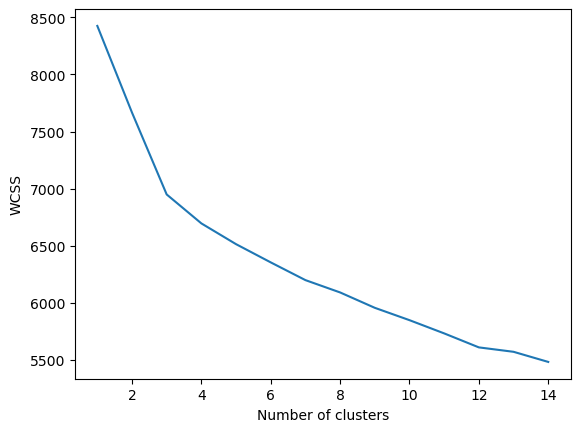

In [7]:
# Gráfico de cotovelo, para identificar número ideal de clusters
wcss = [] 
for i in range(1, 15): 
    kmeans = KMeans(n_clusters = i, n_init = 15, random_state = 42)
    kmeans.fit(corpus_embeddings) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()


In [8]:
# Clusterização, usando K-Means
k = 12  # Número esperado de clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(corpus_embeddings)

KMeans(n_clusters=12, n_init=10, random_state=42)

In [21]:
# Quantidade de leis por cluster

cls_dist=pd.Series(kmeans.labels_).value_counts().reset_index()
cls_dist.columns = ['Cluster', 'Num_Leis']
cls_dist['Cluster'] = cls_dist['Cluster']+1
cls_dist.sort_values('Cluster')

,Cluster,Num_Leis
8,1,13
3,2,28
2,3,29
0,4,43
9,5,12
6,6,23
10,7,10
1,8,39
4,9,28
7,10,17


In [10]:
# Exemplo de ementa mais próxima a cada centróide
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,corpus_embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")


Cluster		Size		Center-idx		Center-Example
0		13		215		denomina rodovia alfeu teodoro de oliveira o trecho da rodovia br-272 entre as cidades de campo mourao e goioere, no estado do parana .
1		28		104		dispoe sobre a criacao de funcoes comissionadas e cargos efetivos no quadro de pessoal do conselho nacional de justica; e altera a lei no 11.416, de 15 de dezembro de 2006 .   mensagem de veto
2		29		14		abre ao orcamento fiscal da uniao, em favor das justicas federal e do trabalho, e do ministerio publico da uniao, credito suplementar no valor de r$ 5.087.628,00, para reforco de dotacoes constantes da lei orcamentaria vigente.
3		43		110		institui a politica de bem-estar, saude e qualidade de vida no trabalho e valorizacao dos profissionais da educacao .
4		12		48		inscreve o nome de dulcina de moraes no livro dos herois e heroinas da patria .
5		23		190		institui o programa bolsa familia; altera a lei no 8.742, de 7 de dezembro de 1993 (lei organica da assistencia social), a lei no 10.

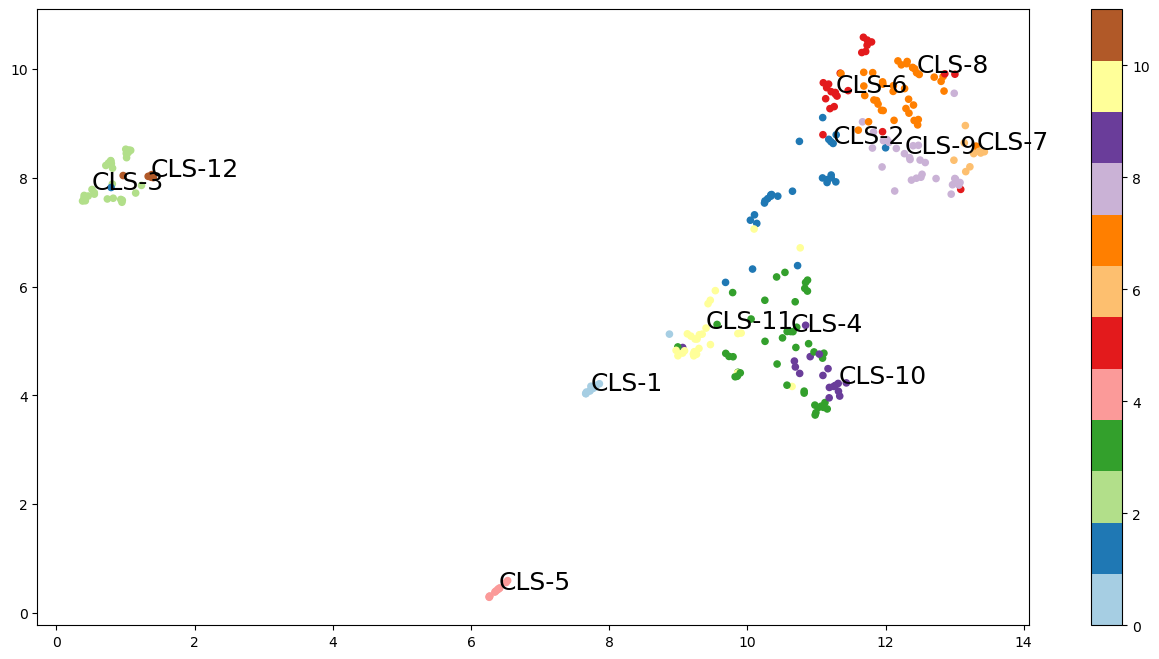

In [22]:
# Reduzindo dimensionalidade e plotando clusters identificados
X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_

fig, ax = plt.subplots(figsize=(16,8))

plt.scatter(X[:,0], X[:,1], c=labels, s=20, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c+1), fontsize=18)
plt.colorbar()

In [12]:
leis['cluster'] = labels

In [13]:
leis.head()

,lei,assunto,assunto_limpo,assunto_lista_termos,cluster
0,"Lei nº 14.791, de 29.12.2023Publicada no DOU d...",Dispõe sobre as diretrizes para a elaboração e...,dispoe sobre as diretrizes para a elaboracao e...,"[dispoe, sobre, as, diretrizes, para, a, elabo...",1
1,"Lei nº 14.790, de 29.12.2023Publicada no DOU d...",Dispõe sobre a modalidade lotérica denominada ...,dispoe sobre a modalidade loterica denominada ...,"[dispoe, sobre, a, modalidade, loterica, denom...",5
2,"Lei nº 14.789, de 29.12.2023Publicada no DOU d...",Dispõe sobre o crédito fiscal decorrente de su...,dispoe sobre o credito fiscal decorrente de su...,"[dispoe, sobre, o, credito, fiscal, decorrente...",5
3,"Lei nº 14.788, de 28.12.2023Publicada no DOU d...","Altera a Lei nº 9.532, de 10 de dezembro de 19...","altera a lei no 9.532, de 10 de dezembro de 19...","[altera, a, lei, no, 9532, de, 10, de, dezembr...",7
4,"Lei nº 14.787, de 28.12.2023Publicada no DOU d...","Altera a Lei nº 11.033, de 21 de dezembro de 2...","altera a lei no 11.033, de 21 de dezembro de 2...","[altera, a, lei, no, 11033, de, 21, de, dezemb...",8


In [14]:
# Wordcloud dos clusters

stopwords = nltk.corpus.stopwords.words('portuguese')+['', 'institui', 'dispor', 'dispoe', 'nacional', 'decreto', 'mensagem', 'veto', 'decretolei', 
                                                       'decreto-lei', 'revoga', 'art', 'arts', 'inciso', 
                                                       'caput', 'leis', 'altera', 'lei', 'nao', 'no', 'nº', 
                                                       'dispoe', 'legislacao', 'sobre', 'acrescenta', 'janeiro', 
                                                       'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 
                                                       'agosto', 'setembro', 'outubro', 'novembro', 'dezembro', 
                                                       '1o', '2o', '3o', '4o', '5o', '6o', '7o', '8o', '9o', 
                                                       '10o', '11o', '1º', '2º', '3º', '4º', '5º', '6º', '7º', 
                                                       '8º', '9º', '10º', '11º']

def cria_word_cloud(cluster):
    lista_termos = [k for k in leis[leis['cluster']==cluster]['assunto_lista_termos'].sum() if k not in stopwords]
    lista_termos = [k for k in lista_termos if k.isnumeric()==False]
    termos=(' ').join(lista_termos)
    wordcloud = WordCloud().generate(termos)
    # Generate plot
    plt.imshow(wordcloud)
    plt.axis("off")
    return plt.show()

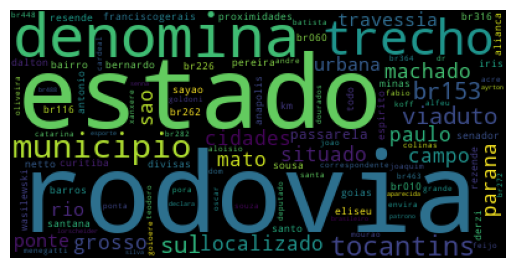

0 None


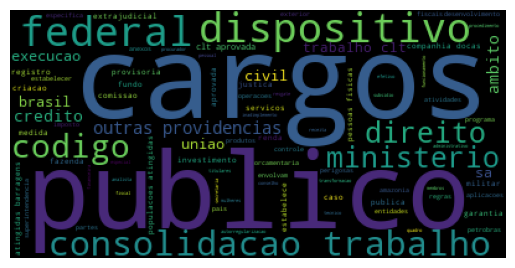

1 None


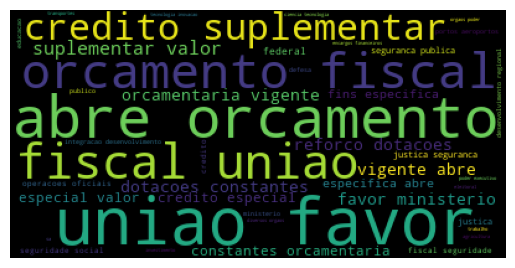

2 None


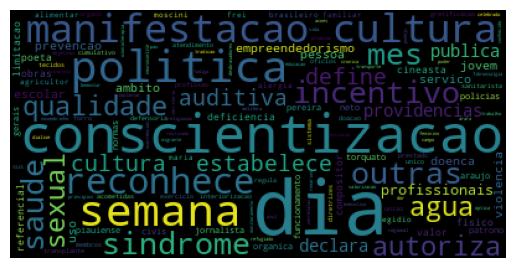

3 None


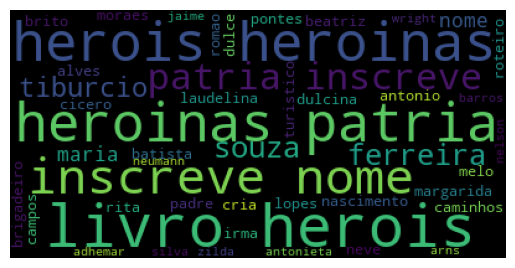

4 None


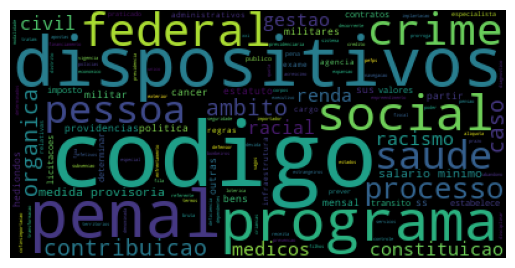

5 None


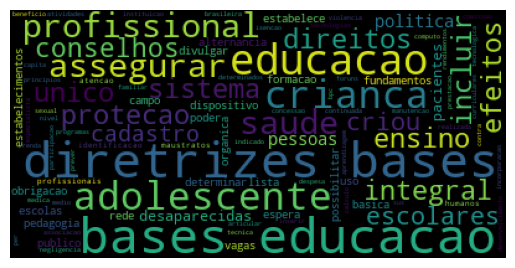

6 None


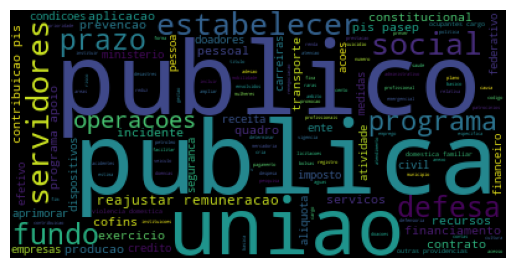

7 None


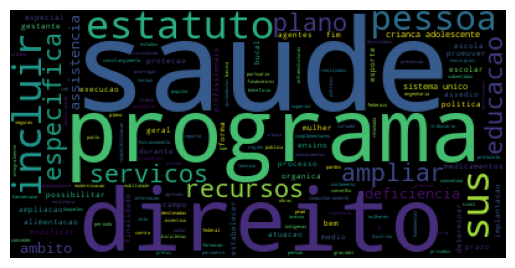

8 None


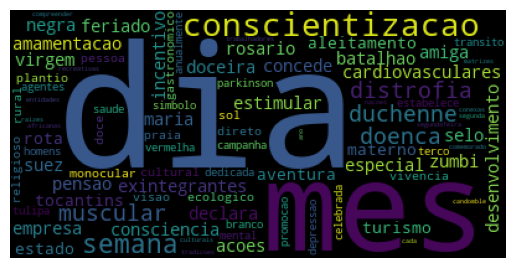

9 None


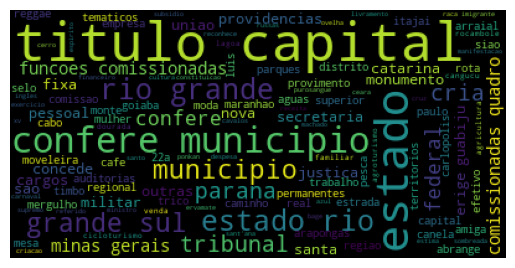

10 None


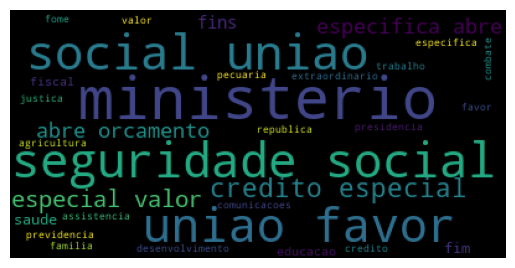

11 None


In [24]:
for i in range(k):
    print(i, cria_word_cloud(i))

In [16]:
leis.to_excel('_planilha_leis_clusters.xlsx')